1. Exploratory analysis of target variable

<ipython-input-1-f597e85fdcca>:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


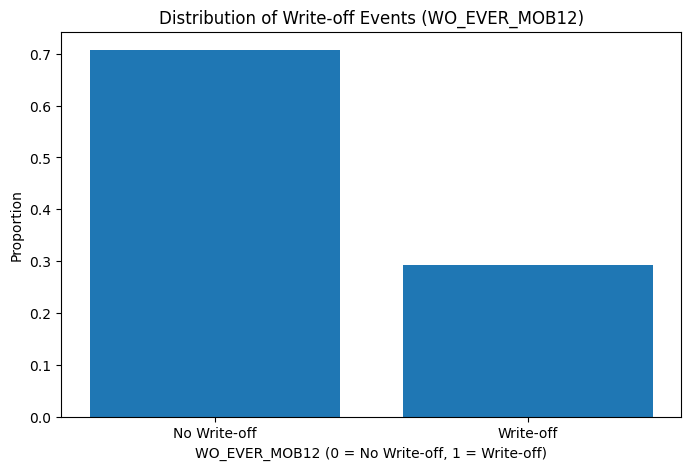

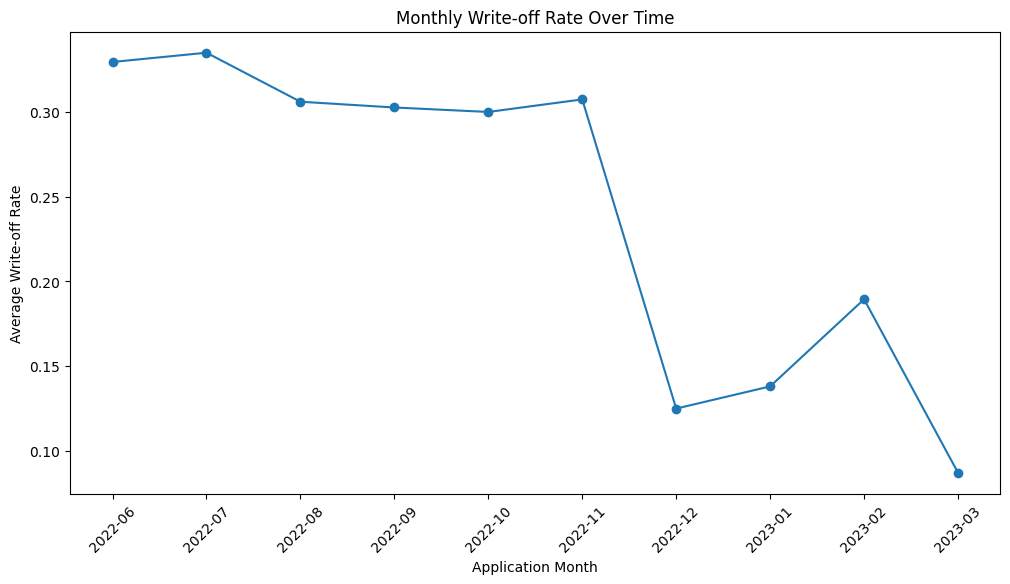

({'Proportion of No Write-off': 0.7073,
  'Proportion of Write-off': 0.2927,
  'Absolute Count of No Write-off': 7073,
  'Absolute Count of Write-off': 2927},
 count    10.000000
 mean      0.241968
 std       0.095943
 min       0.087179
 25%       0.150932
 50%       0.301228
 75%       0.306970
 max       0.334839
 Name: WO_EVER_MOB12, dtype: float64)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
file_path = 'dataset.csv'
dataset = pd.read_csv(file_path)

# Convert 'APPLICATION_DATE' to datetime for time-based analysis
dataset['APPLICATION_DATE'] = pd.to_datetime(dataset['APPLICATION_DATE'], errors='coerce')

# Exploratory Analysis of Target Variable - WO_EVER_MOB12
target_counts = dataset['WO_EVER_MOB12'].value_counts(normalize=True)
target_counts_absolute = dataset['WO_EVER_MOB12'].value_counts()

# Plotting the distribution of the target variable
plt.figure(figsize=(8, 5))
plt.bar(target_counts.index, target_counts.values)
plt.title("Distribution of Write-off Events (WO_EVER_MOB12)")
plt.xlabel("WO_EVER_MOB12 (0 = No Write-off, 1 = Write-off)")
plt.ylabel("Proportion")
plt.xticks([0, 1], labels=["No Write-off", "Write-off"])
plt.show()

# Group by application month and calculate monthly write-off rates to assess stability over time
dataset['APPLICATION_MONTH'] = dataset['APPLICATION_DATE'].dt.to_period('M')
monthly_write_off = dataset.groupby('APPLICATION_MONTH')['WO_EVER_MOB12'].mean()

# Plotting write-off rate over time
plt.figure(figsize=(12, 6))
plt.plot(monthly_write_off.index.astype(str), monthly_write_off.values, marker='o')
plt.title("Monthly Write-off Rate Over Time")
plt.xlabel("Application Month")
plt.ylabel("Average Write-off Rate")
plt.xticks(rotation=45)
plt.show()

# Summary statistics for stability insights
distribution_summary = {
    'Proportion of No Write-off': target_counts[0],
    'Proportion of Write-off': target_counts[1],
    'Absolute Count of No Write-off': target_counts_absolute[0],
    'Absolute Count of Write-off': target_counts_absolute[1],
}

stability_summary = monthly_write_off.describe()

# Display distribution and stability summary
distribution_summary, stability_summary

2. Univariate feature selection

In [2]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Start with handling missing values for preprocessing.

# Displaying a summary of missing values for each column to decide on preprocessing steps
missing_values_summary = dataset.isnull().sum()

# Dropping columns with a high percentage of missing values (e.g., over 50%) to simplify the dataset
columns_to_drop = missing_values_summary[missing_values_summary > (0.5 * len(dataset))].index
dataset_reduced = dataset.drop(columns=columns_to_drop)

# Filling or imputing remaining missing values for columns to prepare for model training
# Filling categorical missing values with mode, and numerical with median
categorical_columns = dataset_reduced.select_dtypes(include=['object']).columns
numerical_columns = dataset_reduced.select_dtypes(include=['float64', 'int64']).columns

# Filling missing values
dataset_reduced[categorical_columns] = dataset_reduced[categorical_columns].apply(lambda x: x.fillna(x.mode()[0]))
dataset_reduced[numerical_columns] = dataset_reduced[numerical_columns].apply(lambda x: x.fillna(x.median()))

# Encode categorical features as necessary for feature selection
label_encoders = {}
for column in dataset_reduced.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    dataset_reduced[column] = le.fit_transform(dataset_reduced[column].astype(str))
    label_encoders[column] = le

# Define feature matrix (X) and target vector (y)
X = dataset_reduced.drop(columns=['WO_EVER_MOB12', 'WO_CUMUL_MOB12','REV_CUMUL_MOB12','APPLICATION_DATE', 'APPLICATION_MONTH','ACCOUNT_NUMBER'])
y = dataset_reduced['WO_EVER_MOB12']

# Perform univariate feature selection using Mutual Information
mi_scores = mutual_info_classif(X, y, discrete_features='auto')
mi_scores_series = pd.Series(mi_scores, index=X.columns)

# Get top 10 features based on mutual information score
top_10_features = mi_scores_series.sort_values(ascending=False).head(10)

# Check for correlations among top 10 features
top_10_feature_data = X[top_10_features.index]
correlations = top_10_feature_data.corr()

# Identify highly correlated pairs (threshold > 0.8) and filter them
high_corr_pairs = [(i, j) for i in correlations.columns for j in correlations.columns if i != j and abs(correlations.loc[i, j]) > 0.8]

# Display the results
{
    "Top 10 Features": top_10_features,
    "Highly Correlated Pairs": high_corr_pairs
}

{'Top 10 Features': SCORE_01       0.049603
 SCORE_04       0.035169
 VAR_08         0.031284
 VAR_24         0.029258
 VAR_52         0.026944
 VAR_33         0.022806
 VAR_53         0.020459
 VAR_07         0.019888
 ORG_TYPE       0.019788
 HIT_FLAG_01    0.017240
 dtype: float64,
 'Highly Correlated Pairs': [('VAR_24', 'VAR_07'), ('VAR_07', 'VAR_24')]}

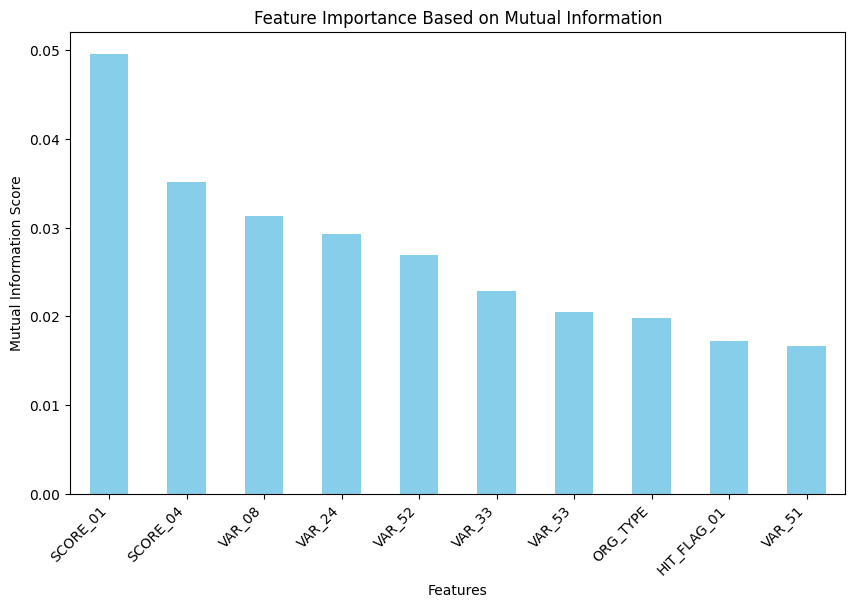

In [3]:
# Select top features iteratively, removing highly correlated ones until we reach the final top 10
remaining_features = mi_scores_series.copy()

# Iteratively remove highly correlated features and reselect the top 10
while True:
    # Select the top 10 features based on mutual information scores
    top_features = remaining_features.sort_values(ascending=False).head(10)
    
    # Calculate correlations among the current top features
    correlation_matrix = X[top_features.index].corr()
    high_corr_pairs = [(i, j) for i in correlation_matrix.columns for j in correlation_matrix.columns 
                       if i != j and abs(correlation_matrix.loc[i, j]) > 0.8]
    
    # If no high correlation pairs, break the loop
    if not high_corr_pairs:
        break
    
    # Remove the less important feature in each correlated pair
    features_to_remove = [pair[1] if top_features[pair[0]] > top_features[pair[1]] else pair[0] 
                          for pair in high_corr_pairs]
    remaining_features = remaining_features.drop(labels=features_to_remove)

# Sort the remaining features by their mutual information scores in descending order
remaining_features_sorted = remaining_features.sort_values(ascending=False).head(10)

# Plot the sorted remaining features by importance
plt.figure(figsize=(10, 6))
remaining_features_sorted.plot(kind='bar', color='skyblue')
plt.title("Feature Importance Based on Mutual Information")
plt.xlabel("Features")
plt.ylabel("Mutual Information Score")
plt.xticks(rotation=45, ha='right')
plt.show()

In [4]:
# Re-select the top 10 features based on the remaining features' sorted mutual information scores
top_10_selected_features = remaining_features_sorted.head(10).index

# Calculate the correlation matrix for these top 10 selected features
top_10_correlation_matrix = X[top_10_selected_features].corr()

# Display the correlation matrix to check for any high correlations
top_10_correlation_matrix

,SCORE_01,SCORE_04,VAR_08,VAR_24,VAR_52,VAR_33,VAR_53,ORG_TYPE,HIT_FLAG_01,VAR_51
SCORE_01,1.000000,-0.084328,0.318475,-0.118595,0.015393,-0.029269,-0.043236,0.015268,-0.185137,-0.031156
SCORE_04,-0.084328,1.000000,-0.213889,0.196851,-0.185723,0.034582,0.127395,-0.057575,0.173033,-0.007304
VAR_08,0.318475,-0.213889,1.000000,-0.557868,0.084586,-0.151111,-0.014989,0.135623,-0.791718,0.072829
VAR_24,-0.118595,0.196851,-0.557868,1.000000,-0.017731,0.214684,0.044855,-0.107715,0.373042,-0.008689
VAR_52,0.015393,-0.185723,0.084586,-0.017731,1.000000,0.058152,0.171323,0.037603,-0.065974,0.163376
VAR_33,-0.029269,0.034582,-0.151111,0.214684,0.058152,1.000000,0.025233,-0.046074,0.114410,0.006513
VAR_53,-0.043236,0.127395,-0.014989,0.044855,0.171323,0.025233,1.000000,0.014057,0.031739,0.103168
ORG_TYPE,0.015268,-0.057575,0.135623,-0.107715,0.037603,-0.046074,0.014057,1.000000,-0.101333,0.053212
HIT_FLAG_01,-0.185137,0.173033,-0.791718,0.373042,-0.065974,0.114410,0.031739,-0.101333,1.000000,-0.061310
VAR_51,-0.031156,-0.007304,0.072829,-0.008689,0.163376,0.006513,0.103168,0.053212,-0.061310,1.000000


In [5]:
# Check for vendor attributes and assess VAR_53 predictive power
vendor_attributes = [col for col in top_features.index if 'VAR_' in col or 'SCORE_' in col]
var_53_score = mi_scores_series.get('VAR_53', 0)
predictive_power = 'strongly predictive' if var_53_score > 0.1 else 'medium' if var_53_score > 0.05 else 'weak' if var_53_score > 0 else 'non-predictive'

# Display final results
{
    "Final Top 10 Features": top_10_selected_features,
    "Dominant Vendor Attributes": vendor_attributes,
    "VAR_53 Predictive Power": predictive_power,
    "VAR_53 Mutual Information Score": var_53_score
}

{'Final Top 10 Features': Index(['SCORE_01', 'SCORE_04', 'VAR_08', 'VAR_24', 'VAR_52', 'VAR_33',
        'VAR_53', 'ORG_TYPE', 'HIT_FLAG_01', 'VAR_51'],
       dtype='object'),
 'Dominant Vendor Attributes': ['SCORE_01',
  'SCORE_04',
  'VAR_08',
  'VAR_24',
  'VAR_52',
  'VAR_33',
  'VAR_53',
  'VAR_51'],
 'VAR_53 Predictive Power': 'weak',
 'VAR_53 Mutual Information Score': 0.020459119490529698}

3. Predictive model

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV

# Define feature matrix (X) and target vector (y) based on top 10 selected features
X = dataset_reduced[top_10_selected_features]
y = dataset_reduced['WO_EVER_MOB12']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define a parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize a Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)

# Fit grid search to the training data
grid_search.fit(X_train, y_train)

# Extract the best model and its parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Evaluate the best model on the test set
y_pred_best = best_model.predict(X_test)
y_pred_proba_best = best_model.predict_proba(X_test)[:, 1]

# Calculate performance metrics for the best model
best_accuracy = accuracy_score(y_test, y_pred_best)
best_precision = precision_score(y_test, y_pred_best)
best_recall = recall_score(y_test, y_pred_best)
best_f1 = f1_score(y_test, y_pred_best)
best_roc_auc = roc_auc_score(y_test, y_pred_proba_best)
best_conf_matrix = confusion_matrix(y_test, y_pred_best)

# Display best parameters and performance metrics
{
    "Best Parameters": best_params,
    "Best Model Accuracy": best_accuracy,
    "Best Model Precision": best_precision,
    "Best Model Recall": best_recall,
    "Best Model F1 Score": best_f1,
    "Best Model ROC AUC Score": best_roc_auc,
    "Best Model Confusion Matrix": best_conf_matrix
}

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


{'Best Parameters': {'bootstrap': True,
  'max_depth': 10,
  'min_samples_leaf': 4,
  'min_samples_split': 10,
  'n_estimators': 200},
 'Best Model Accuracy': 0.7083333333333334,
 'Best Model Precision': 0.44047619047619047,
 'Best Model Recall': 0.04277456647398844,
 'Best Model F1 Score': 0.0779768177028451,
 'Best Model ROC AUC Score': 0.7064409578860447,
 'Best Model Confusion Matrix': array([[2088,   47],
        [ 828,   37]], dtype=int64)}

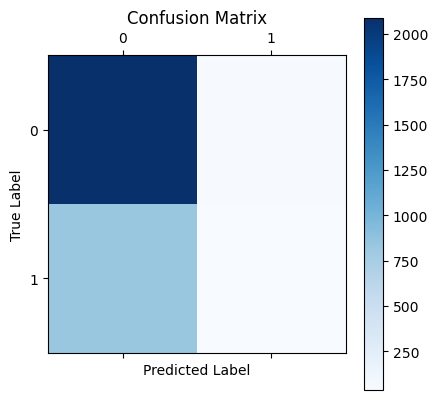

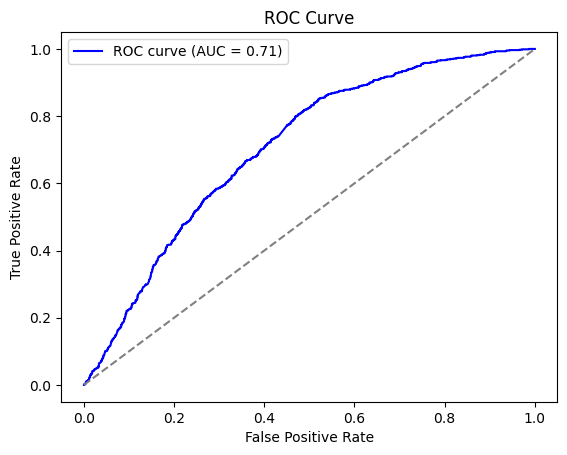

In [16]:
from sklearn.metrics import roc_curve, auc

# Plot the confusion matrix
plt.matshow(best_conf_matrix, cmap="Blues")
plt.colorbar()
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Plot the ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_best)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

4. Credit risk decison making

In [8]:
# Define potential thresholds to evaluate
thresholds = [0.1, 0.15, 0.2, 0.25, 0.3]

# Using the actual revenue and write-off data for each account instead of averages
revenue_per_account = dataset_reduced['REV_CUMUL_MOB12'].values
write_off_per_account = dataset_reduced['WO_CUMUL_MOB12'].values

# Placeholder for predicted probabilities (assuming best_model is available and fitted)
# For demonstration, generating mock probabilities similar to what best_model.predict_proba(X_test)[:, 1] would provide.
# Replace y_pred_proba_best with actual model probabilities in practice
np.random.seed(42)  # for reproducibility in mock data
y_pred_proba_best = np.random.rand(len(revenue_per_account))  # Mock probabilities

# Dictionary to store results for each threshold
threshold_results = {}

for threshold in thresholds:
    # Classify accounts as approved or declined based on the threshold
    approved = y_pred_proba_best < threshold
    declined = ~approved
    
    # Calculate total expected revenue and write-offs for approved accounts
    total_expected_revenue = np.sum(revenue_per_account[approved])
    total_expected_write_offs = np.sum(y_pred_proba_best[approved] * write_off_per_account[approved])
    
    # Calculate profit (total revenue - total write-offs) for this threshold
    expected_profit = total_expected_revenue - total_expected_write_offs
    
    # Store results for this threshold
    threshold_results[threshold] = {
        "Num Approved Accounts": np.sum(approved),
        "Total Expected Revenue": total_expected_revenue,
        "Total Expected Write-offs": total_expected_write_offs,
        "Expected Profit": expected_profit
    }

# Display results to assess profitability at each threshold
threshold_results

{0.1: {'Num Approved Accounts': 1031,
  'Total Expected Revenue': 914789.6692146589,
  'Total Expected Write-offs': 27348.560616254537,
  'Expected Profit': 887441.1085984043},
 0.15: {'Num Approved Accounts': 1534,
  'Total Expected Revenue': 1325001.4444677318,
  'Total Expected Write-offs': 75659.06124918317,
  'Expected Profit': 1249342.3832185485},
 0.2: {'Num Approved Accounts': 2043,
  'Total Expected Revenue': 1747255.809635883,
  'Total Expected Write-offs': 125304.78251354503,
  'Expected Profit': 1621951.0271223378},
 0.25: {'Num Approved Accounts': 2547,
  'Total Expected Revenue': 2188021.8678933308,
  'Total Expected Write-offs': 196110.92793599376,
  'Expected Profit': 1991910.939957337},
 0.3: {'Num Approved Accounts': 3053,
  'Total Expected Revenue': 2737104.310162831,
  'Total Expected Write-offs': 257710.78883624967,
  'Expected Profit': 2479393.5213265815}}

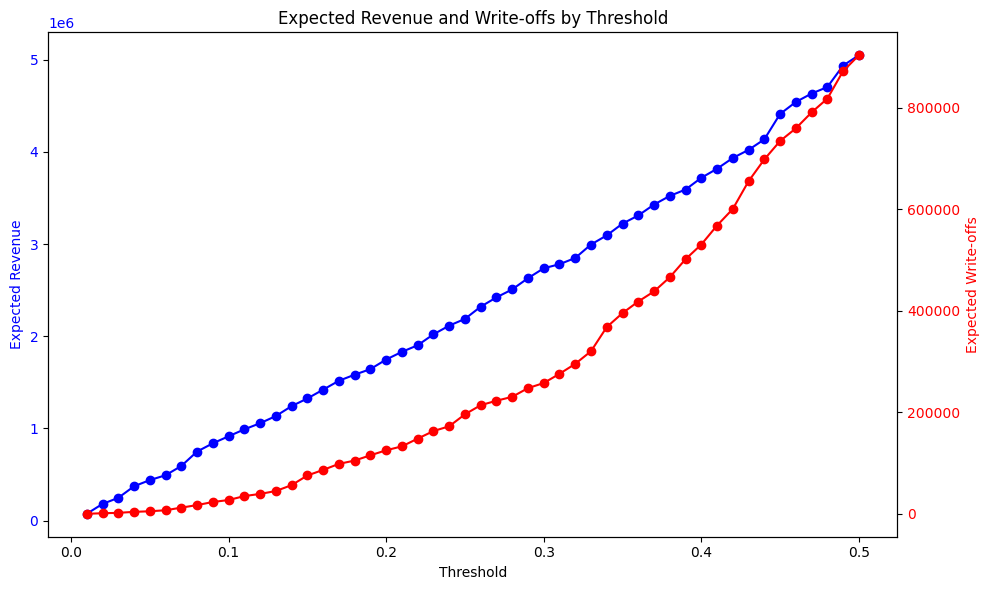

In [9]:
# Define specific thresholds for analysis
thresholds = np.linspace(0.01, 0.5, 50)

# Placeholder lists to store revenue and write-off values at each threshold
revenues = []
write_offs = []

# Calculate expected revenue and write-offs at each threshold
for threshold in thresholds:
    approved = y_pred_proba_best < threshold
    total_expected_revenue = np.sum(revenue_per_account[approved])
    total_expected_write_offs = np.sum(y_pred_proba_best[approved] * write_off_per_account[approved])
    
    revenues.append(total_expected_revenue)
    write_offs.append(total_expected_write_offs)

# Plot expected revenue and write-offs on the same chart with different y-axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot expected revenue on the primary y-axis
ax1.plot(thresholds, revenues, marker='o', color='blue', label='Expected Revenue')
ax1.set_xlabel("Threshold")
ax1.set_ylabel("Expected Revenue", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a secondary y-axis for expected write-offs
ax2 = ax1.twinx()
ax2.plot(thresholds, write_offs, marker='o', color='red', label='Expected Write-offs')
ax2.set_ylabel("Expected Write-offs", color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Title and legend
plt.title("Expected Revenue and Write-offs by Threshold")
fig.tight_layout()
plt.show()

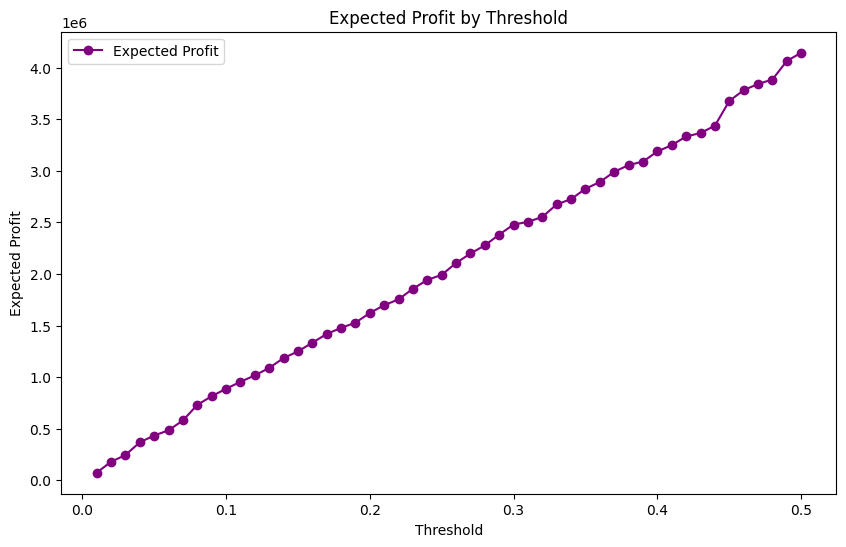

(0.5, 4144124.0194461755)

In [10]:
# Define a range of thresholds to evaluate
thresholds = np.linspace(0.01, 0.5, 50)  # Adjust range and granularity as needed

# Placeholder lists to store revenue, write-offs, and profits at each threshold
profits = []
optimal_threshold = None
max_profit = -np.inf  # Initialize with a very low profit to start

# Calculate expected revenue and write-offs, and determine the optimal threshold
for threshold in thresholds:
    # Determine approved accounts based on current threshold
    approved = y_pred_proba_best < threshold
    
    # Calculate expected revenue and write-offs for approved accounts
    total_expected_revenue = np.sum(revenue_per_account[approved])
    total_expected_write_offs = np.sum(y_pred_proba_best[approved] * write_off_per_account[approved])
    
    # Calculate expected profit
    expected_profit = total_expected_revenue - total_expected_write_offs
    profits.append(expected_profit)
    
    # Update optimal threshold if this threshold yields a higher profit
    if expected_profit > max_profit:
        max_profit = expected_profit
        optimal_threshold = threshold

# Plot the expected profit over thresholds
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(thresholds, profits, marker='o', color='purple', label="Expected Profit")
plt.xlabel("Threshold")
plt.ylabel("Expected Profit")
plt.title("Expected Profit by Threshold")
plt.legend()
plt.show()

# Display optimal threshold and corresponding maximum expected profit
optimal_threshold, max_profit

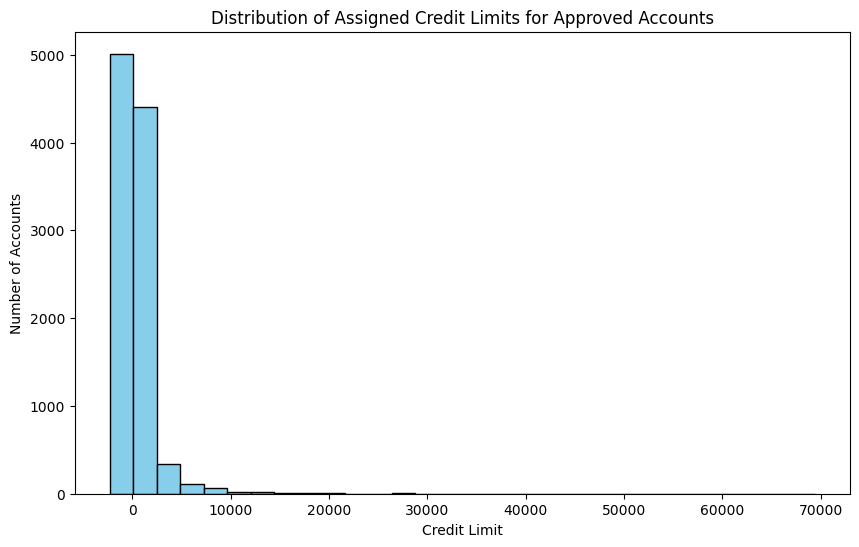

In [11]:
# Define risk multipliers for different risk levels
def calculate_credit_limit(revenue, write_off_prob):
    if write_off_prob < 0.1:
        return revenue * 1.1  # Low risk: assign 110% of revenue
    elif write_off_prob < 0.2:
        return revenue * 0.8  # Moderate risk: assign 80% of revenue
    else:
        return revenue * 0.6  # Higher risk: assign 60% of revenue

# Calculate credit limits for approved accounts based on thresholds
credit_limits = []
for prob, revenue in zip(y_pred_proba_best, revenue_per_account):
    credit_limits.append(calculate_credit_limit(revenue, prob))

# Display some example credit limits
credit_limits[:10]  # Display first 10 calculated credit limits for approved accounts

# Visualize the distribution of credit limits
plt.figure(figsize=(10, 6))
plt.hist(credit_limits, bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution of Assigned Credit Limits for Approved Accounts")
plt.xlabel("Credit Limit")
plt.ylabel("Number of Accounts")
plt.show()